# Панорама из 3 частей (жёстко под Waldo.png, без функций)

Input: (1920, 5113, 3)


Text(0.5, 1.0, 'Waldo.png')

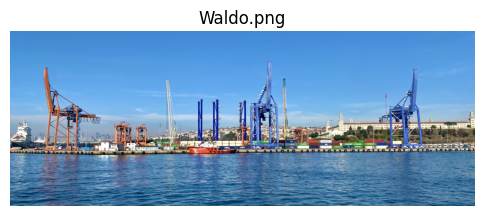

In [25]:
import cv2, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

image_path = Path("Istanbul_port.png")
overlap = 0.8
angle_left  = 17.3
angle_right = 22.7
maxNFeatures = 4000
ratio = 0.75
out_dir = Path("/mnt/data/panorama_waldo_outputs"); out_dir.mkdir(parents=True, exist_ok=True)

bgr = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
if bgr is None:
    raise RuntimeError("Файл не найден")
img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
print("Input:", img.shape)
plt.figure(figsize=(6,4)); plt.imshow(img); plt.axis("off"); plt.title("Waldo.png")

Text(0.5, 1.0, 'Right')

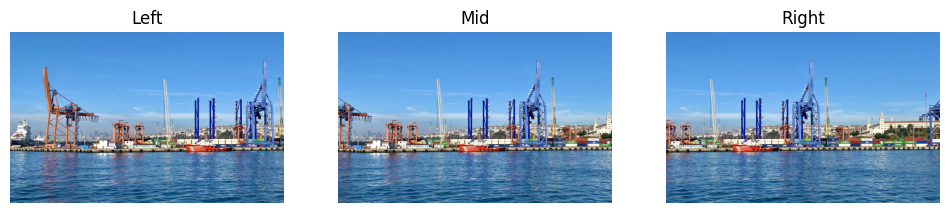

In [26]:
H, W = img.shape[:2]
crop_w = int(0.6 * W)
step = int(crop_w * (1 - overlap))

x0 = 0
x1 = min(W - crop_w, step)
x2 = min(W - crop_w, 2 * step)

crop_left  = img[:, x0:x0+crop_w].copy()
crop_mid   = img[:, x1:x1+crop_w].copy()
crop_right = img[:, x2:x2+crop_w].copy()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(crop_left);  plt.axis("off"); plt.title("Left")
plt.subplot(1,3,2); plt.imshow(crop_mid);   plt.axis("off"); plt.title("Mid")
plt.subplot(1,3,3); plt.imshow(crop_right); plt.axis("off"); plt.title("Right")

Text(0.5, 1.0, 'Right CW 22.7°')

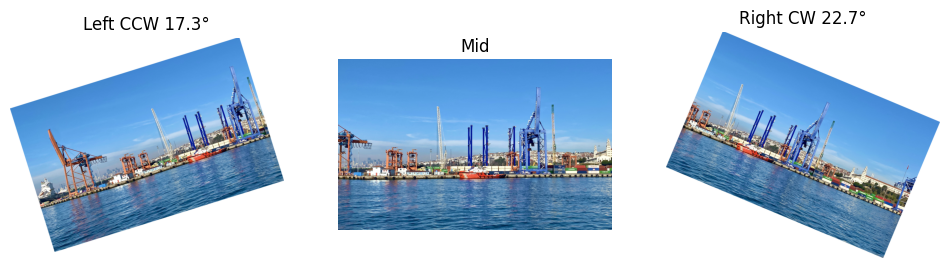

In [27]:
# Повороты с белым фоном и без обрезаний
# Left (CCW)
hL, wL = crop_left.shape[:2]
cL = (wL/2, hL/2)
ML = cv2.getRotationMatrix2D(cL, angle_left, 1.0)
cosL, sinL = abs(ML[0,0]), abs(ML[0,1])
nWL = int(hL*sinL + wL*cosL)
nHL = int(hL*cosL + wL*sinL)
ML[0,2] += (nWL/2) - cL[0]
ML[1,2] += (nHL/2) - cL[1]
left_rot = cv2.warpAffine(
    crop_left, ML, (nWL, nHL),
    flags=cv2.INTER_LINEAR,
    borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255)
)

# Right (CW)
hR, wR = crop_right.shape[:2]
cR = (wR/2, hR/2)
MR = cv2.getRotationMatrix2D(cR, -angle_right, 1.0)
cosR, sinR = abs(MR[0,0]), abs(MR[0,1])
nWR = int(hR*sinR + wR*cosR)
nHR = int(hR*cosR + wR*sinR)
MR[0,2] += (nWR/2) - cR[0]
MR[1,2] += (nHR/2) - cR[1]
right_rot = cv2.warpAffine(
    crop_right, MR, (nWR, nHR),
    flags=cv2.INTER_LINEAR,
    borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255)
)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(left_rot);  plt.axis("off"); plt.title(f"Left CCW {angle_left}°")
plt.subplot(1,3,2); plt.imshow(crop_mid);  plt.axis("off"); plt.title("Mid")
plt.subplot(1,3,3); plt.imshow(right_rot); plt.axis("off"); plt.title(f"Right CW {angle_right}°")


R (rotation 2x2):
 [[ 0.9548168  -0.297195  ]
 [ 0.29719496  0.9548168 ]]
t (translation): [-341.39832 -870.2152 ]
angle_deg: 17.289202


Text(0.5, 1.0, 'Mid')

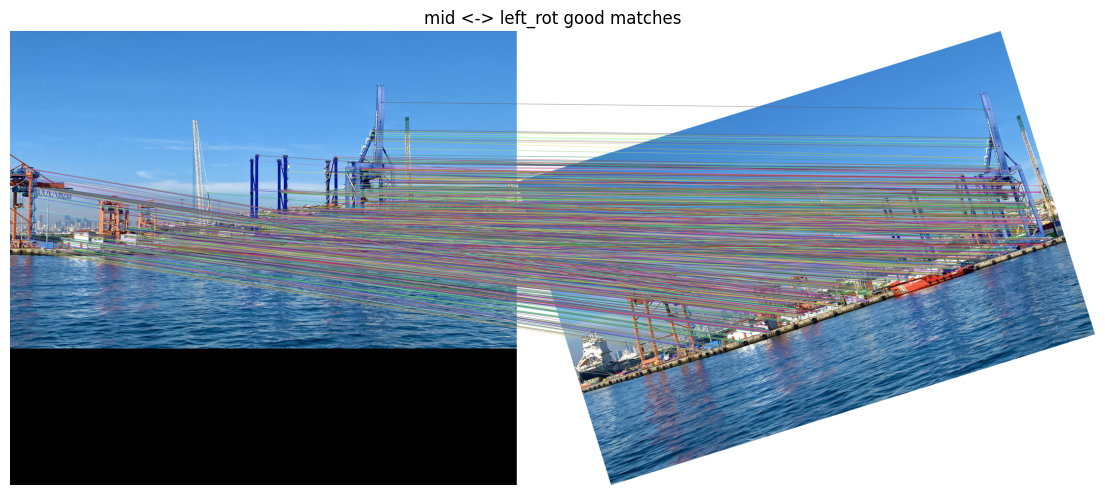

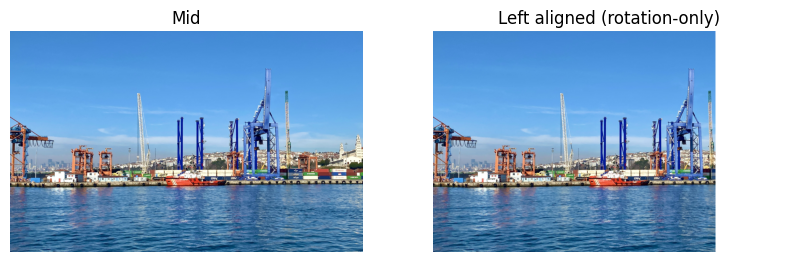

: 

In [ ]:
# ORB + BF KNN (left_rot -> mid)  + РОТАЦИЯ ЧЕРЕЗ KABSCH
img1Gray = cv2.cvtColor(crop_mid,  cv2.COLOR_RGB2GRAY)   # dst
img2Gray = cv2.cvtColor(left_rot,  cv2.COLOR_RGB2GRAY)   # src

orb = cv2.ORB_create(maxNFeatures)
keypoints1, desc1 = orb.detectAndCompute(img1Gray, None)
keypoints2, desc2 = orb.detectAndCompute(img2Gray, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = bf.knnMatch(desc1, desc2, k=2)

good = []
for m, n in matches:
    if m.distance < ratio * n.distance:
        good.append(m)
if len(good) < 6:
    raise RuntimeError(f"Too few good matches: {len(good)}")

# точки только из good
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in good]).reshape(-1,2)  # dst (mid)
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in good]).reshape(-1,2)  # src (left_rot)

# --- Kabsch: чистый поворот + сдвиг (без масштаба и гомографии) ---
# центрируем
mu1 = pts1.mean(axis=0)
mu2 = pts2.mean(axis=0)
X = pts2 - mu2   # src centered
Y = pts1 - mu1   # dst centered

# кросс-ковариация и SVD
C = X.T @ Y                       # 2x2
U, S, Vt = np.linalg.svd(C)
R = Vt.T @ U.T                    # 2x2, поворот src->dst

# гарантируем det(R)=+1 (без отражения)
if np.linalg.det(R) < 0:
    Vt[1,:] *= -1
    R = Vt.T @ U.T

# сдвиг
t = mu1 - (R @ mu2)

# угол поворота (в градусах)
theta = np.degrees(np.arctan2(R[1,0], R[0,0]))

print("R (rotation 2x2):\n", R)
print("t (translation):", t)
print("angle_deg:", theta)

# рисуем мэтчи (как просил)
imMatches_L = cv2.drawMatches(crop_mid, keypoints1, left_rot, keypoints2, good, None)
plt.figure(figsize=(14,6))
plt.imshow(imMatches_L); plt.axis("off"); plt.title("mid <-> left_rot good matches")

# (опционально) проверить результат поворота/сдвига как affine
A = np.hstack([R, t.reshape(2,1)])   # 2x3
th, tw = crop_mid.shape[:2]
left_aligned_rot = cv2.warpAffine(
    left_rot, A, (tw, th),
    flags=cv2.INTER_LINEAR,
    borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255)
)
plt.figure(figsize=(10,4))
plt.subplot(1,2,2); plt.imshow(left_aligned_rot);  plt.axis("off"); plt.title("Left aligned (rotation-only)")
plt.subplot(1,2,1); plt.imshow(crop_mid);         plt.axis("off"); plt.title("Mid")


H_R:
 [[ 9.21483238e-01  3.86169488e-01 -6.99428445e+01]
 [-3.86161099e-01  9.22234789e-01  2.86527093e+02]
 [-4.00407360e-07  5.25710899e-08  1.00000000e+00]]


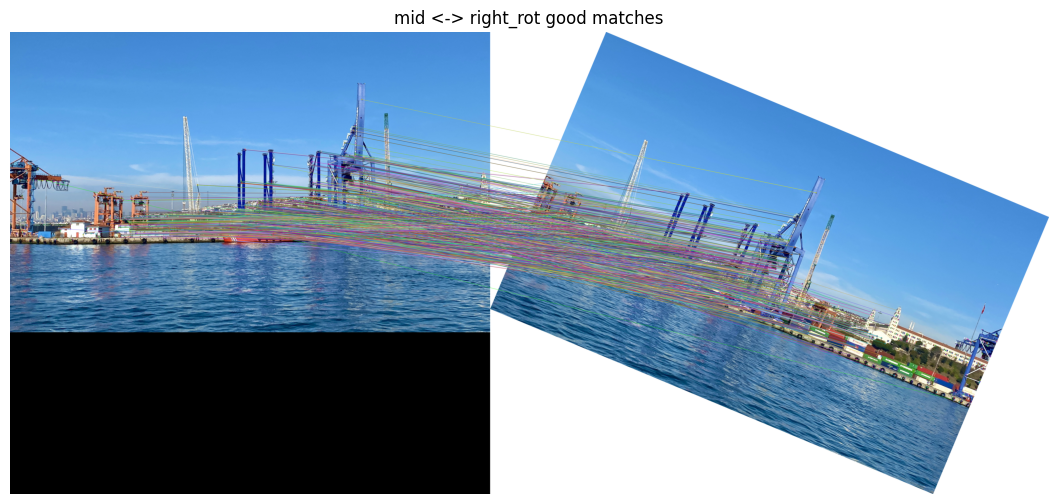

In [46]:
# ORB + BF KNN (right_rot -> mid)
img1Gray_R = cv2.cvtColor(crop_mid,  cv2.COLOR_RGB2GRAY)
img2Gray_R = cv2.cvtColor(right_rot, cv2.COLOR_RGB2GRAY)
orb_R = cv2.ORB_create(maxNFeatures)
keypoints1_R, desc1_R = orb_R.detectAndCompute(img1Gray_R, None)
keypoints2_R, desc2_R = orb_R.detectAndCompute(img2Gray_R, None)
bf_R = cv2.BFMatcher(cv2.NORM_HAMMING)
matches_R = bf_R.knnMatch(desc1_R, desc2_R, k=2)
good_R = []
for m, n in matches_R:
    if m.distance < ratio * n.distance:
        good_R.append(m)
pts1_R = np.float32([keypoints1_R[m.queryIdx].pt for m in good_R]).reshape(-1,1,2)
pts2_R = np.float32([keypoints2_R[m.trainIdx].pt for m in good_R]).reshape(-1,1,2)
H_R, mask_R = cv2.findHomography(pts2_R, pts1_R, cv2.RANSAC, 5.0)
imMatches_R = cv2.drawMatches(crop_mid, keypoints1_R, right_rot, keypoints2_R, good_R, None)
plt.figure(figsize=(14,6)); plt.imshow(imMatches_R); plt.axis("off"); plt.title("mid <-> right_rot good matches")
print("H_R:\n", H_R)

In [39]:
# поворот и отрисовка левой
points1 = np.zeros((len(matches), 2), dtype = np.float32)
points2 = np.zeros((len(matches), 2), dtype = np.float32)

for i, match in enumerate(matches):
    points1[i,:] = keypoints1[match[0].queryIdx].pt
    points2[i,:] = keypoints2[match[0].trainIdx].pt

h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

print(h)

                                                     

[[ 9.50251293e-01 -2.99441694e-01 -3.32954007e+02]
 [ 2.95976707e-01  9.50473472e-01 -8.65242924e+02]
 [-6.11996672e-07 -1.25953942e-06  1.00000000e+00]]


Text(0.5, 1.0, 'Scan updated')

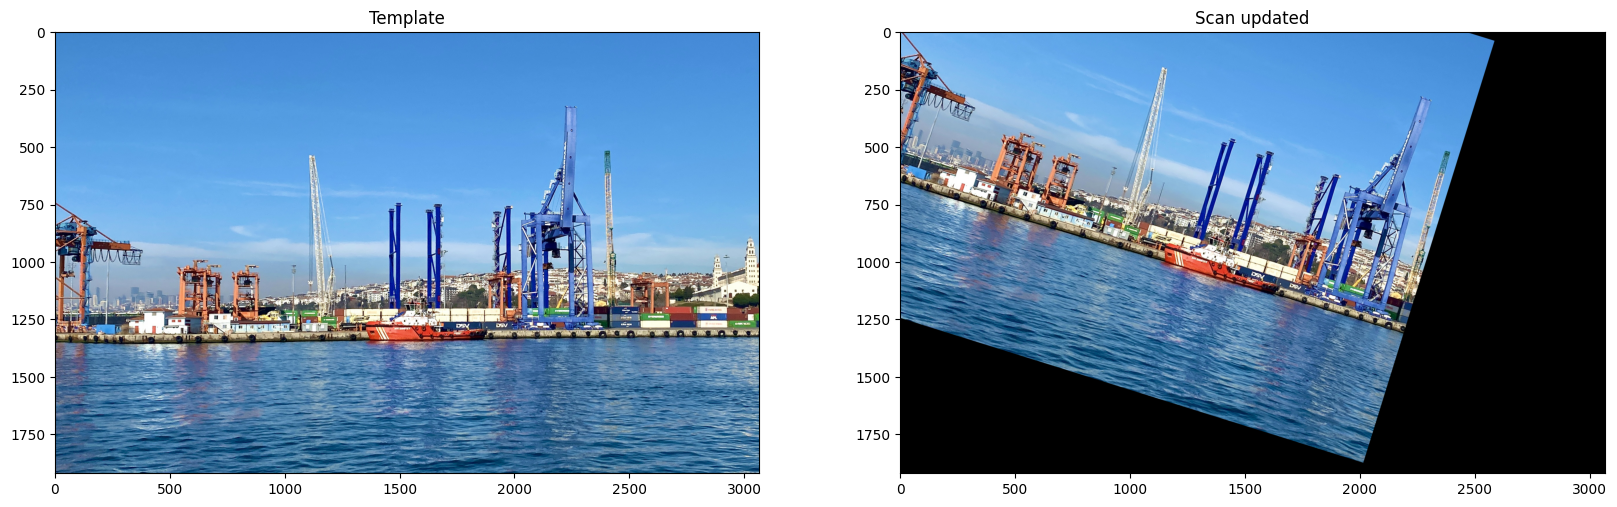

In [47]:
height, width, _ = crop_mid.shape
scanImgUpdated = cv2.warpPerspective(crop_left, h, (width, height))

plt.figure(figsize = [20, 10])
plt.subplot(121); plt.imshow(crop_mid); plt.title("Template")
plt.subplot(122); plt.imshow(scanImgUpdated); plt.title("Scan updated")

Saved: \mnt\data\panorama_waldo_outputs\panorama.png


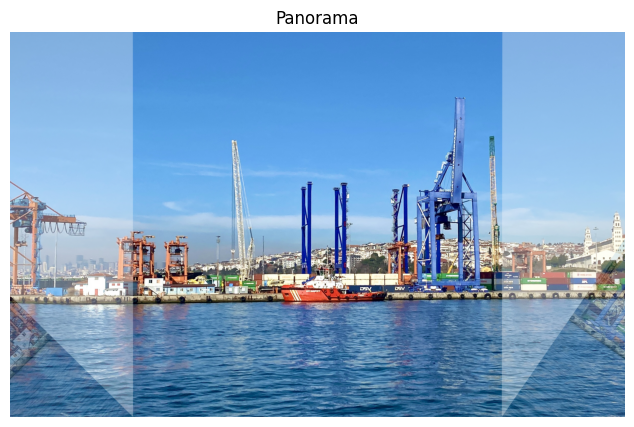

In [31]:
# Feather blend (inline)
mid_canvas = np.zeros_like(left_aligned)
mid_canvas[:th, :tw] = crop_mid

imgs = [left_aligned, mid_canvas, right_aligned]

m0 = cv2.cvtColor(left_aligned,  cv2.COLOR_RGB2GRAY); m0 = (m0>0).astype(np.float32); m0 = cv2.GaussianBlur(m0,(0,0),15)
m1 = np.ones((th, tw), dtype=np.float32)  # mid полностью валиден
m2 = cv2.cvtColor(right_aligned, cv2.COLOR_RGB2GRAY); m2 = (m2>0).astype(np.float32); m2 = cv2.GaussianBlur(m2,(0,0),15)

acc = np.zeros((th, tw, 3), dtype=np.float32)
wacc = np.zeros((th, tw, 1), dtype=np.float32)

for a, m in zip(imgs, [m0, m1, m2]):
    m3 = np.dstack([m, m, m])
    acc += a.astype(np.float32) * m3
    wacc += m[...,None]

wacc[wacc==0] = 1.0
panorama = (acc / wacc).clip(0,255).astype(np.uint8)

import cv2
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5)); plt.imshow(panorama); plt.axis("off"); plt.title("Panorama")
from pathlib import Path
cv2.imwrite(str(Path("/mnt/data/panorama_waldo_outputs/panorama.png")), cv2.cvtColor(panorama, cv2.COLOR_RGB2BGR))
print("Saved:", Path("/mnt/data/panorama_waldo_outputs/panorama.png"))